# Bijective Map Log Analysis

This notebook analyzes the bijective_map_log_{id}.txt files to categorize them into:
- **Success**: Files ending with "curves topology is correct" and "finished check curves topology"
- **Error**: Files with "error" (case insensitive) in the last 20 lines
- **Incomplete**: Files that don't complete but have no errors
- **Empty**: Empty files

In [1]:
import os
import glob
import re
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Set up paths
log_dir = "test_log"
pattern = "bijective_map_log_*.txt"
log_files = glob.glob(os.path.join(log_dir, pattern))

print(f"Found {len(log_files)} bijective map log files")
print(f"First few files: {log_files[:5]}")

Found 412 bijective map log files
First few files: ['test_log/bijective_map_log_78736.txt', 'test_log/bijective_map_log_37747.txt', 'test_log/bijective_map_log_40915.txt', 'test_log/bijective_map_log_38110.txt', 'test_log/bijective_map_log_77940.txt']


In [3]:
def analyze_log_file(filepath):
    """
    Analyze a single log file and return its status.
    
    Returns:
        tuple: (status, details)
        status: 'success', 'error', 'incomplete', 'empty'
        details: additional information about the file
    """
    try:
        # Check if file exists and get size
        if not os.path.exists(filepath):
            return 'missing', 'File does not exist'
        
        file_size = os.path.getsize(filepath)
        if file_size == 0:
            return 'empty', 'File is empty'
        
        with open(filepath, 'r', encoding='utf-8', errors='ignore') as f:
            lines = f.readlines()
        
        if len(lines) == 0:
            return 'empty', 'No content in file'
        
        # Check last two lines for success pattern
        if len(lines) >= 2:
            last_line = lines[-1].strip().lower()
            second_last_line = lines[-2].strip().lower()
            
            if ("curves topology is correct" in second_last_line and 
                "finished check curves topology" in last_line):
                return 'success', f'Completed successfully ({len(lines)} lines)'
        
        # Check last 20 lines for errors
        last_20_lines = lines[-20:] if len(lines) >= 20 else lines
        error_found = False
        error_line = ""
        
        for i, line in enumerate(last_20_lines):
            if re.search(r'error', line, re.IGNORECASE):
                error_found = True
                error_line = line.strip()
                break
        
        if error_found:
            return 'error', f'Error found: "{error_line}" ({len(lines)} lines)'
        
        # If no success pattern and no error, it's incomplete
        return 'incomplete', f'Did not complete ({len(lines)} lines)'
        
    except Exception as e:
        return 'error', f'Exception while reading file: {str(e)}'

In [4]:
# Analyze all log files
results = {}
status_counts = defaultdict(int)

print("Analyzing log files...\n")

for log_file in sorted(log_files):
    # Extract ID from filename
    filename = os.path.basename(log_file)
    match = re.search(r'bijective_map_log_(\d+)\.txt', filename)
    file_id = match.group(1) if match else 'unknown'
    
    status, details = analyze_log_file(log_file)
    results[file_id] = {
        'filename': filename,
        'status': status,
        'details': details
    }
    status_counts[status] += 1
    
    # Print status for each file
    print(f"{filename}: {status.upper()} - {details}")

print(f"\nAnalyzed {len(results)} files")

Analyzing log files...

bijective_map_log_32770.txt: INCOMPLETE - Did not complete (23279 lines)
bijective_map_log_34783.txt: INCOMPLETE - Did not complete (57724 lines)
bijective_map_log_34785.txt: INCOMPLETE - Did not complete (33970 lines)
bijective_map_log_35269.txt: INCOMPLETE - Did not complete (25217 lines)
bijective_map_log_36069.txt: SUCCESS - Completed successfully (3935 lines)
bijective_map_log_36075.txt: SUCCESS - Completed successfully (4201 lines)
bijective_map_log_36082.txt: SUCCESS - Completed successfully (3848 lines)
bijective_map_log_36086.txt: SUCCESS - Completed successfully (8889 lines)
bijective_map_log_36090.txt: SUCCESS - Completed successfully (8896 lines)
bijective_map_log_36372.txt: SUCCESS - Completed successfully (3940 lines)
bijective_map_log_36373.txt: SUCCESS - Completed successfully (8898 lines)
bijective_map_log_37003.txt: INCOMPLETE - Did not complete (121015 lines)
bijective_map_log_37004.txt: INCOMPLETE - Did not complete (65605 lines)
bijective_ma

In [5]:
# Create summary statistics
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)

total_files = len(results)
print(f"Total files analyzed: {total_files}\n")

for status, count in sorted(status_counts.items()):
    percentage = (count / total_files) * 100
    print(f"{status.upper():<12}: {count:>3} files ({percentage:>5.1f}%)")

print("\nDetailed breakdown:")
print("-" * 40)

# Group by status for detailed view
by_status = defaultdict(list)
for file_id, data in results.items():
    by_status[data['status']].append((file_id, data))

for status in ['success', 'error', 'incomplete', 'empty', 'missing']:
    if status in by_status:
        print(f"\n{status.upper()} files ({len(by_status[status])}):")  
        for file_id, data in sorted(by_status[status]):
            print(f"  {data['filename']}: {data['details']}")


SUMMARY STATISTICS
Total files analyzed: 412

EMPTY       :  14 files (  3.4%)
ERROR       :  15 files (  3.6%)
INCOMPLETE  : 132 files ( 32.0%)
SUCCESS     : 251 files ( 60.9%)

Detailed breakdown:
----------------------------------------

SUCCESS files (251):
  bijective_map_log_36069.txt: Completed successfully (3935 lines)
  bijective_map_log_36075.txt: Completed successfully (4201 lines)
  bijective_map_log_36082.txt: Completed successfully (3848 lines)
  bijective_map_log_36086.txt: Completed successfully (8889 lines)
  bijective_map_log_36090.txt: Completed successfully (8896 lines)
  bijective_map_log_36372.txt: Completed successfully (3940 lines)
  bijective_map_log_36373.txt: Completed successfully (8898 lines)
  bijective_map_log_37093.txt: Completed successfully (7103 lines)
  bijective_map_log_37095.txt: Completed successfully (6854 lines)
  bijective_map_log_37274.txt: Completed successfully (7751 lines)
  bijective_map_log_37276.txt: Completed successfully (9368 lines)


In [6]:
# Create a DataFrame for easier analysis
df_data = []
for file_id, data in results.items():
    df_data.append({
        'file_id': int(file_id) if file_id.isdigit() else file_id,
        'filename': data['filename'],
        'status': data['status'],
        'details': data['details']
    })

df = pd.DataFrame(df_data)
if not df.empty:
    df = df.sort_values('file_id')

print("\nDataFrame created with results:")
print(df.head(10))


DataFrame created with results:
   file_id                     filename      status  \
0    32770  bijective_map_log_32770.txt  incomplete   
1    34783  bijective_map_log_34783.txt  incomplete   
2    34785  bijective_map_log_34785.txt  incomplete   
3    35269  bijective_map_log_35269.txt  incomplete   
4    36069  bijective_map_log_36069.txt     success   
5    36075  bijective_map_log_36075.txt     success   
6    36082  bijective_map_log_36082.txt     success   
7    36086  bijective_map_log_36086.txt     success   
8    36090  bijective_map_log_36090.txt     success   
9    36372  bijective_map_log_36372.txt     success   

                               details  
0       Did not complete (23279 lines)  
1       Did not complete (57724 lines)  
2       Did not complete (33970 lines)  
3       Did not complete (25217 lines)  
4  Completed successfully (3935 lines)  
5  Completed successfully (4201 lines)  
6  Completed successfully (3848 lines)  
7  Completed successfully (8889 l

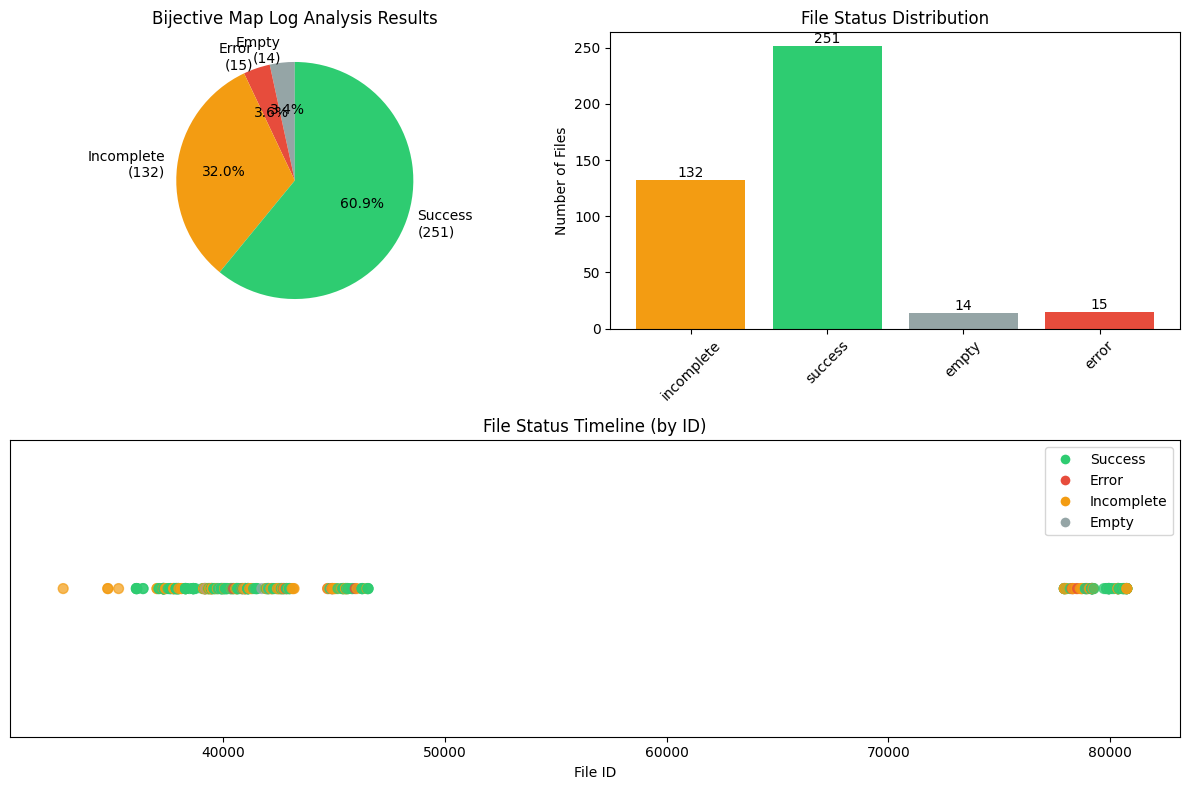

In [7]:
# Create visualization
plt.figure(figsize=(12, 8))

# Pie chart
plt.subplot(2, 2, 1)
labels = []
sizes = []
colors = ['#2ecc71', '#e74c3c', '#f39c12', '#95a5a6', '#9b59b6']
color_map = {'success': '#2ecc71', 'error': '#e74c3c', 'incomplete': '#f39c12', 
             'empty': '#95a5a6', 'missing': '#9b59b6'}

for status, count in sorted(status_counts.items()):
    labels.append(f'{status.title()}\n({count})')
    sizes.append(count)

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90,
        colors=[color_map.get(status.lower(), '#95a5a6') for status in [s.split('\n')[0].lower() for s in labels]])
plt.title('Bijective Map Log Analysis Results')

# Bar chart
plt.subplot(2, 2, 2)
statuses = list(status_counts.keys())
counts = list(status_counts.values())
bars = plt.bar(statuses, counts, color=[color_map.get(s, '#95a5a6') for s in statuses])
plt.title('File Status Distribution')
plt.ylabel('Number of Files')
plt.xticks(rotation=45)

# Add value labels on bars
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.1,
             str(count), ha='center', va='bottom')

# Timeline of file IDs (if numeric)
if not df.empty and df['file_id'].dtype != 'object':
    plt.subplot(2, 1, 2)
    status_colors = df['status'].map(color_map)
    plt.scatter(df['file_id'], [1]*len(df), c=status_colors, alpha=0.7, s=50)
    plt.xlabel('File ID')
    plt.ylabel('')
    plt.title('File Status Timeline (by ID)')
    plt.yticks([])
    
    # Add legend
    legend_elements = []
    for status, color in color_map.items():
        if status in status_counts:
            legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
                                            markerfacecolor=color, markersize=8, label=status.title()))
    plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

In [8]:
# Save results to CSV for further analysis
if not df.empty:
    output_file = 'bijective_map_analysis_results.csv'
    df.to_csv(output_file, index=False)
    print(f"\nResults saved to: {output_file}")
    
    # Save summary statistics
    summary_file = 'bijective_map_analysis_summary.txt'
    with open(summary_file, 'w') as f:
        f.write("Bijective Map Log Analysis Summary\n")
        f.write("=" * 40 + "\n\n")
        f.write(f"Total files analyzed: {total_files}\n\n")
        
        for status, count in sorted(status_counts.items()):
            percentage = (count / total_files) * 100
            f.write(f"{status.upper()}: {count} files ({percentage:.1f}%)\n")
    
    print(f"Summary saved to: {summary_file}")
else:
    print("No data to save")


Results saved to: bijective_map_analysis_results.csv
Summary saved to: bijective_map_analysis_summary.txt


In [20]:
# Get all error IDs for detailed analysis
if not df.empty:
    error_ids = df[df['status'] == 'error']['file_id'].tolist()
    print(f"\nError File IDs ({len(error_ids)} total):")
    if error_ids:
        # Sort the error IDs if they are numeric
        try:
            error_ids_sorted = sorted([int(id) for id in error_ids])
            print(error_ids_sorted)
        except (ValueError, TypeError):
            # If not numeric, sort as strings
            error_ids_sorted = sorted(error_ids)
            print(error_ids_sorted)
        
        # Save error IDs to file
        error_ids_file = 'error_file_ids.txt'
        with open(error_ids_file, 'w') as f:
            f.write("Error File IDs\n")
            f.write("=" * 15 + "\n\n")
            for error_id in error_ids_sorted:
                f.write(f"{error_id}\n")
        print(f"Error IDs saved to: {error_ids_file}")
        
        # Print last 10 lines of each error file's log
        print(f"\nLast 10 lines for each error file:")
        print("=" * 50)
        for error_id in error_ids_sorted:
            log_file = f"./test_log/bijective_map_log_{error_id}.txt"
            print(f"\nFile ID: {error_id}")
            print("-" * 30)
            try:
                with open(log_file, 'r') as f:
                    lines = f.readlines()
                    last_lines = lines[-10:] if len(lines) >= 10 else lines
                    for line in last_lines:
                        print(line.rstrip())
            except FileNotFoundError:
                print(f"Log file not found: {log_file}")
            except Exception as e:
                print(f"Error reading log file: {e}")
    else:
        print("No error files found")
else:
    print("No data available to extract error IDs")



Error File IDs (15 total):
[40450, 40844, 40900, 42727, 42839, 42840, 44704, 44910, 45945, 78295, 78322, 78538, 78970, 79239, 80751]
Error IDs saved to: error_file_ids.txt

Last 10 lines for each error file:

File ID: 40450
------------------------------
curve 6 and curve 8 intersect 0 times
intersections between curve 6 and curve 8 are correct
--------------------------------
curve 7 has 0 self intersections
curve 7 and curve 8 intersect 0 times
intersections between curve 7 and curve 8 are correct
--------------------------------
curve 8 has 0 self intersections
Error: curves topology is not correct
finished check curves topology

File ID: 40844
------------------------------
Handling Consolidate forward
clean up curve, segments size: 171 -> 171
Handling Consolidate forward
clean up curve, segments size: 187 -> 187
finished
clean up curve, segments size: 219 -> 219
clean up curve, segments size: 214 -> 214
finished
Error: vid not found in next_seg.fv_ids
Error: curve is not valid af